Import Libararies and Load the Dataset

In [129]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

# load dataset
dataframe = pandas.read_csv("../data/heart_disease_dataset_UCI.csv")


Visualize the data

In [130]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


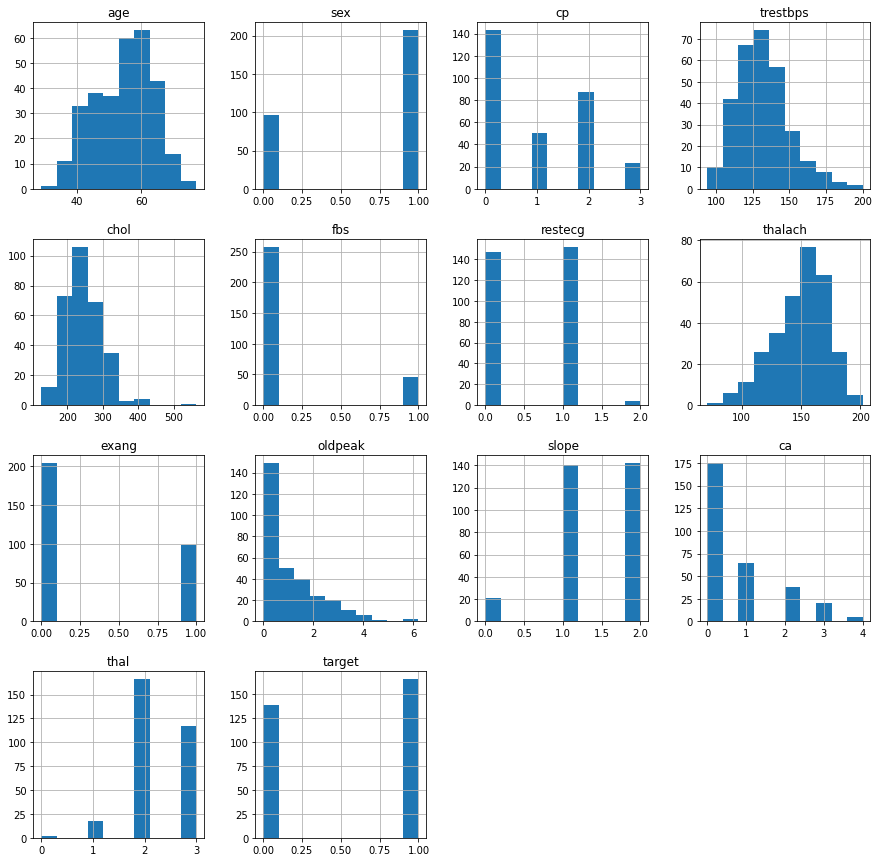

In [131]:
dataframe.hist(figsize=(15,15));

Preprocess the Data

In [132]:
columns_to_scale = ['age','trestbps','chol','thalach','oldpeak']
#Normalize and update in place
dataframe[columns_to_scale] = StandardScaler().fit_transform(dataframe[columns_to_scale])

Segregate Data

In [133]:
#Split the independent and dependent variables
X = dataframe.iloc[:,0:13]
Y = dataframe.iloc[:,13]
trainX,testX,trainY,testY = model_selection.train_test_split(X,Y,test_size=0.25,random_state=979551)

Apply Logistic regression

In [134]:
lr_l1 = LogisticRegression('l1', C=0.6, solver='liblinear').fit(trainX,trainY)
pred_l1 = lr_l1.predict(testX)

lr_l2 = LogisticRegression('l2', C=0.6, solver='liblinear').fit(trainX,trainY)
pred_l2 = lr_l2.predict(testX)

Extract Stats/Results

In [135]:
conf_mat_l1=confusion_matrix(testY,pred_l1)
conf_mat_l2=confusion_matrix(testY,pred_l2)

In [136]:
print(lr_l1.score(testX, testY))
print(lr_l2.score(testX, testY))

0.8026315789473685
0.8421052631578947


<AxesSubplot:>

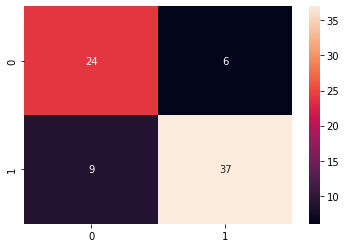

In [137]:
sns.heatmap(conf_mat_l1,annot=True)

<AxesSubplot:>

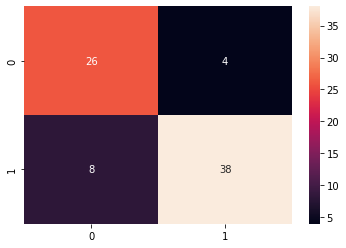

In [138]:
sns.heatmap(conf_mat_l2,annot=True)

In [139]:
from sklearn.metrics import classification_report
print(classification_report(testY,pred_l1))
print(classification_report(testY,pred_l2))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76        30
           1       0.86      0.80      0.83        46

    accuracy                           0.80        76
   macro avg       0.79      0.80      0.80        76
weighted avg       0.81      0.80      0.80        76

              precision    recall  f1-score   support

           0       0.76      0.87      0.81        30
           1       0.90      0.83      0.86        46

    accuracy                           0.84        76
   macro avg       0.83      0.85      0.84        76
weighted avg       0.85      0.84      0.84        76

